In [1]:
import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(9620)
sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

## Population Definition

### Bivariate Normal

In [2]:
size = 1000000
rho_xy = 0.25
sigma_x = 1
sigma_y = 1
cov_xy = rho_xy * (sigma_x * sigma_y)
cov = np.array([[sigma_x**2,    cov_xy], 
                [ cov_xy,   sigma_y**2]])
m = rho_xy * sigma_y / sigma_x
b = 0

population_dist = stats.multivariate_normal(cov=cov)
population_sample = population_dist.rvs(size)
x, y = population_sample[:, 0], population_sample[:, 1]
r_xy = stats.pearsonr(x, y)[0]
m_best =  r_xy * np.std(y) / np.std(x)
b_best =  np.mean(y) - m_best*np.mean(x)

print("Population Correlation:", r_xy)

Population Correlation: 0.25009924154069596


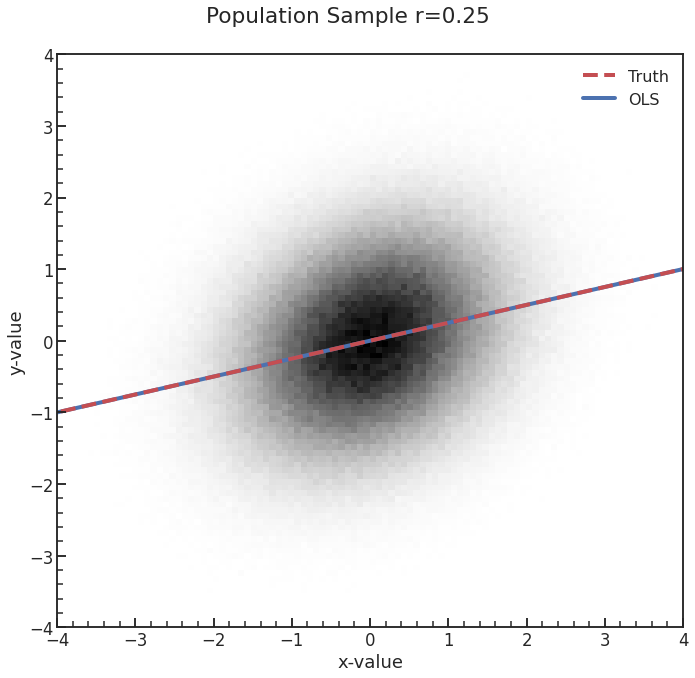

In [3]:
def f(x, m, b):
    return m*x + b

fig = plt.figure(figsize=(10, 10))
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap="gray_r");

xrange = np.linspace(-6, 6, 100)
plt.plot(xrange, f(xrange, m_best, b_best), 'r--', label="Truth")


popt, _ = curve_fit(f, x, y)
plt.plot(xrange, f(xrange, *popt), label="OLS", zorder=1)

fig.suptitle("Population Sample r=0.25")
plt.xlabel("x-value")
plt.ylabel("y-value")
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figures/bivariate.png")

## Measurement Sample

Each measurement sample will be measured with error of constant variance. 

* The first sample will have equal variance on x and y error. 
* The second sample will have x error be 5 times greater than y error. 
* The third will have x error be 10 times greater than y error.

In [4]:
data_size = 100
data_idx = np.random.randint(0, size, size=data_size)

sigma_x = np.ones(data_size) * 0.2
sigma_y = np.ones(data_size) * 0.2
xerr = stats.norm(loc=0, scale=sigma_x).rvs(data_size)
yerr = stats.norm(loc=0, scale=sigma_y).rvs(data_size)

### Measurement Sample 1

Both x and y has single value errors with error ratio of 1.

,x,xerr,y,yerr
45,-3.165259,0.2,-0.069478,0.2
23,-2.661631,0.2,-2.038675,0.2
70,-1.933387,0.2,-1.515904,0.2
61,-1.842759,0.2,0.703586,0.2
22,-1.819805,0.2,-0.046608,0.2


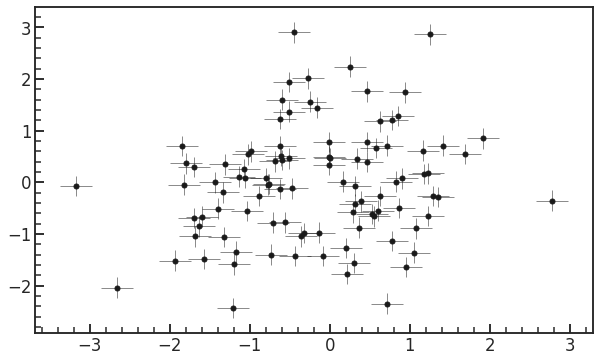

In [5]:
xdata = x[data_idx] + xerr*1
ydata = y[data_idx] + yerr*1

df1 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df1.x, df1.y, yerr=df1.yerr, xerr=df1.xerr, c='k', fmt='ko', lw=0.5, ms=5)
df1.head()

### Measurement Sample 2

Both x and y has single value errors with error ratio x of y being 5

,x,xerr,y,yerr
45,-4.482937,1.0,-0.069478,0.2
19,-3.483037,1.0,-0.690053,0.2
23,-3.418448,1.0,-2.038675,0.2
90,-2.490513,1.0,-1.340855,0.2
84,-2.362619,1.0,0.365568,0.2


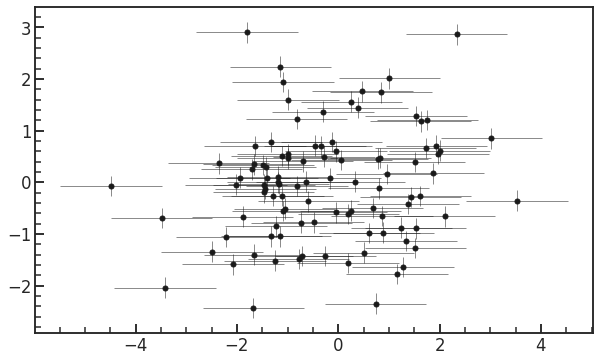

In [6]:
xdata = x[data_idx] + xerr*5
ydata = y[data_idx] + yerr

df2 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*5,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df2.x, df2.y, yerr=df2.yerr, xerr=df2.xerr, fmt='ko', lw=0.5, ms=5)
df2.head()

### Measurement Sample 3

Both x and y has errors of variance uniformly assigned. The error ratio is about 5

,x,xerr,y,yerr
45,-4.482937,1.0,-0.069478,0.2
19,-3.483037,1.0,-0.690053,0.2
23,-3.418448,1.0,-2.038675,0.2
90,-2.490513,1.0,-1.340855,0.2
84,-2.362619,1.0,0.365568,0.2


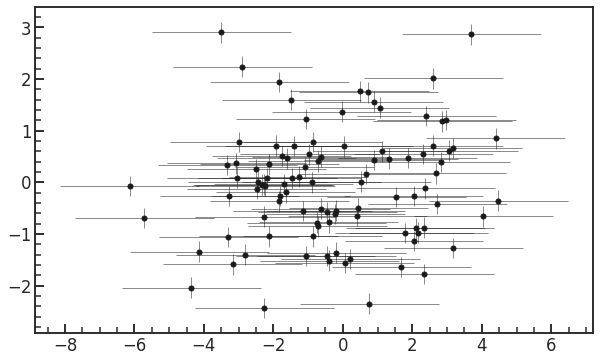

In [7]:
xdata = x[data_idx] + xerr*10
ydata = y[data_idx] + yerr

df3 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*10,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df3.x, df3.y, yerr=df3.yerr, xerr=df3.xerr, fmt='ko', lw=0.5, ms=5)
df2.head()

## Regression Dilution in OLS

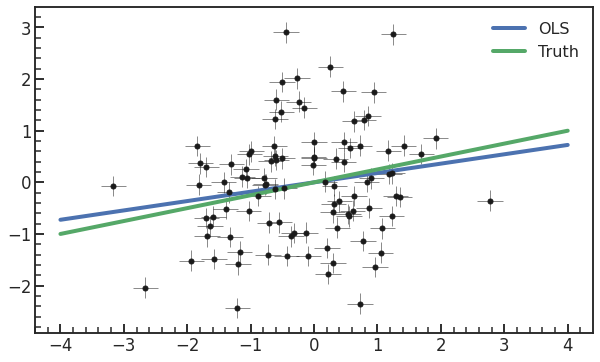

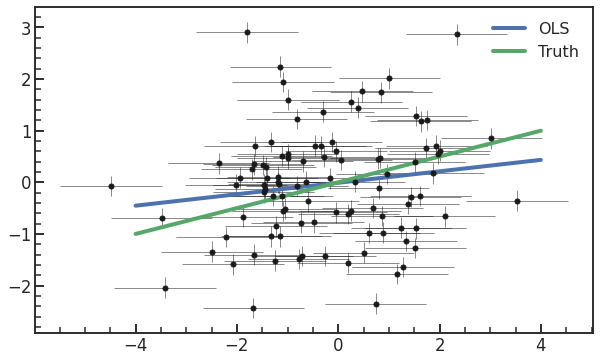

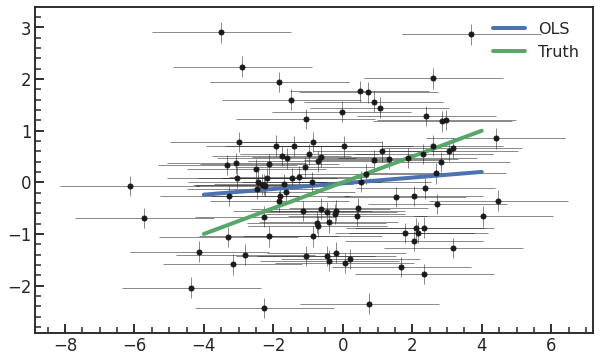

In [8]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

def get_intercept_parameter(x, y, slope):
    """Return the mean of the OLS intercept parameter"""
    corr = stats.pearsonr(x, y)[0]
    intercept = np.mean(y) - slope*np.mean(x)
    
    return intercept

slope, slope_var = get_slope_parameter(df1.x, df1.y)
intercept = get_intercept_parameter(df1.x, df1.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df1.x, df1.y, yerr=df1.yerr, xerr=df1.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")

plt.legend()

slope, slope_var = get_slope_parameter(df2.x, df2.y)
intercept = get_intercept_parameter(df2.x, df2.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df2.x, df2.y, yerr=df2.yerr, xerr=df2.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")
plt.legend()

slope, slope_var = get_slope_parameter(df3.x, df3.y)
intercept = get_intercept_parameter(df3.x, df3.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df3.x, df3.y, yerr=df3.yerr, xerr=df3.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")
plt.legend()

## Regression Dilution in Simulation

In [9]:
def simulate(x, y, xerr, yerr, repetition=1000):
    
    corrs = []
    slopes = []
    intercepts = []
    for i in range(repetition):
        xdist = stats.norm(loc=x, scale=xerr)
        ydist = stats.norm(loc=y, scale=yerr)
        
        xsample = xdist.rvs()
        ysample = ydist.rvs()
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
    
    
    
    return pd.DataFrame({"corr": corrs, "slope": slopes, "intercept": intercept})


result_df1 = simulate(df1.x, df1.y, df1.xerr, df1.yerr)
result_df2 = simulate(df2.x, df2.y, df2.xerr, df2.yerr)
result_df3 = simulate(df3.x, df3.y, df3.xerr, df3.yerr)

In [10]:
# def simulate(x, y, xerr, yerr, sample_size=10000):
    
#     xsample = []
#     ysample = []
#     for i in range(len(x)):
#         xdist = stats.norm(loc=x[i], scale=xerr[i])
#         ydist = stats.norm(loc=y[i], scale=yerr[i])
        
#         xsample.extend(xdist.rvs(size=sample_size))
#         ysample.extend(ydist.rvs(size=sample_size))
    
#     df = pd.DataFrame({
#         "x": xsample,
#         "y": ysample
#     })
    
#     return df


# s1_df = simulate(df1.x, df1.y, df1.xerr, df1.yerr)
# s2_df = simulate(df2.x, df2.y, df2.xerr, df2.yerr)
# s3_df = simulate(df3.x, df3.y, df3.xerr, df3.yerr)

# small_s1_df = simulate(df1.x, df1.y, df1.xerr, df1.yerr, sample_size=50)
# small_s2_df = simulate(df2.x, df2.y, df2.xerr, df2.yerr, sample_size=50)
# small_s3_df = simulate(df3.x, df3.y, df3.xerr, df3.yerr, sample_size=50)

## Regression Dilution in LINMIX

In [11]:
from linmix import linmix

lm1 = linmix.LinMix(df1.x, df1.y, df1.xerr, df1.yerr, K=3)
lm1.run_mcmc(silent=True, maxiter=5000)

lm2 = linmix.LinMix(df2.x, df2.y, df2.xerr, df2.yerr, K=3)
lm2.run_mcmc(silent=True, maxiter=5000)

lm3 = linmix.LinMix(df3.x, df3.y, df3.xerr, df3.yerr, K=3)
lm3.run_mcmc(silent=True, maxiter=5000)

,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.181,0.179,1.056,1,0.971,2,0.071,2,2
MC Simulation 10000,0.177,0.174,1.056,2,0.972,3,0.076,3,3
LINMIX,0.188,0.183,1.056,3,0.971,1,0.067,1,1


,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.111,0.152,1.061,1,0.979,2,0.098,1,2
MC Simulation 10000,0.077,0.125,1.062,2,0.985,3,0.125,2,3
LINMIX,0.215,0.403,1.072,3,0.969,1,-0.153,3,1


,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.055,0.117,1.066,1,0.988,2,0.133,1,2
MC Simulation 10000,0.031,0.086,1.067,2,0.994,3,0.164,2,3
LINMIX,0.412,1.849,1.340,3,0.986,1,-1.599,3,1


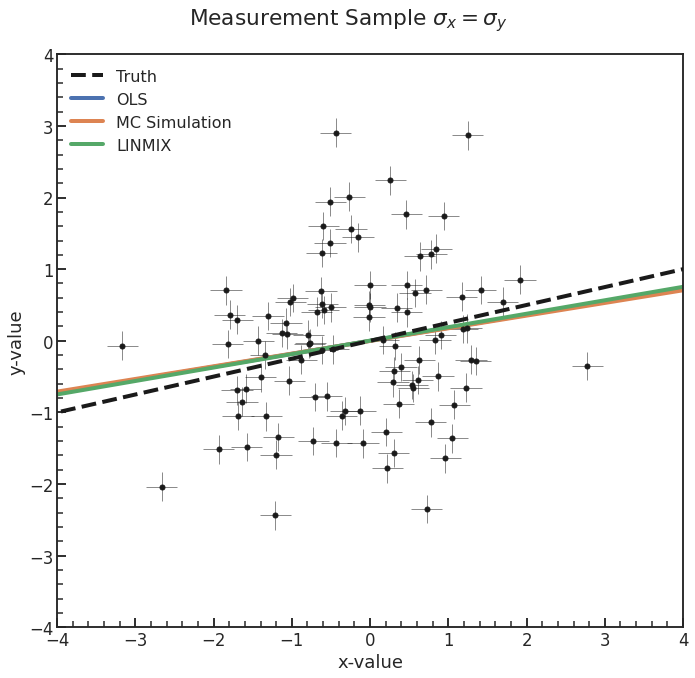

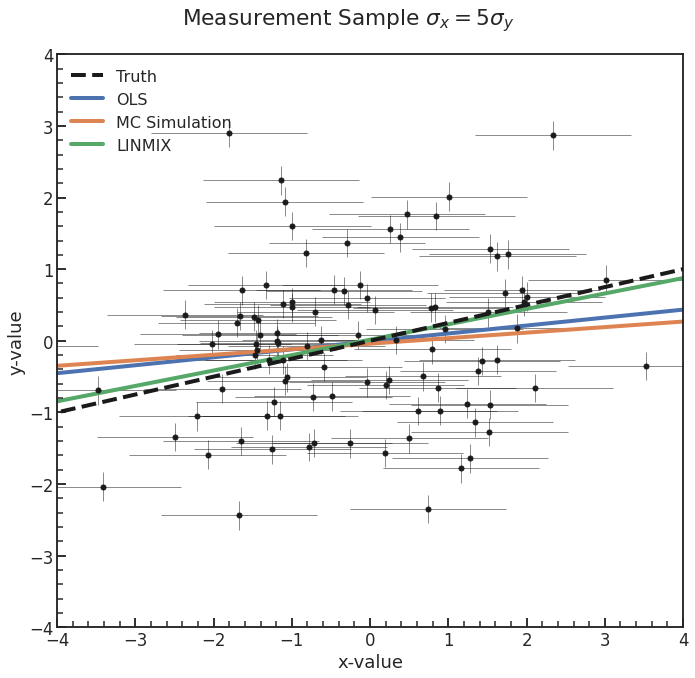

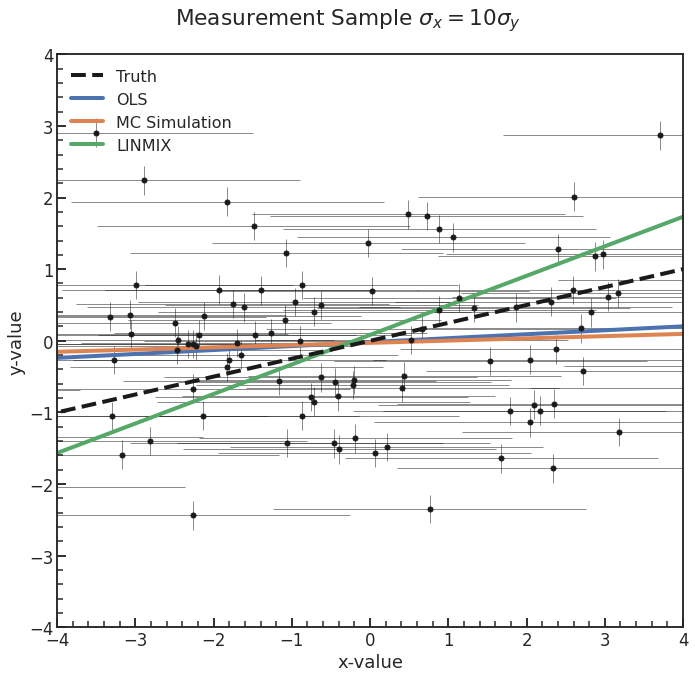

In [12]:
def rmse(y, ypred):
    return np.sqrt(np.mean((y - ypred)**2))

def slope_to_corr(x, y, slope):
    """ THIS IS WRONG """
    return slope * (np.var(x) / np.var(y))

def summary_plot(df, result_df, lm, title=""):
    fig, ax1 = plt.subplots(figsize=(10, 10))
    fig.suptitle(title)
    summary = []
    
    # Truth
    xrange = np.linspace(-6, 6, 100)
    ax1.plot(xrange, f(xrange, m, b), 'k--', label="Truth", zorder=100)

    # Ordinary Least Squares
    slope, slope_var = get_slope_parameter(df.x, df.y)
    corr = stats.pearsonr(df.x, df.y)[0]
    intercept = get_intercept_parameter(df.x, df.y, slope)

    ax1.errorbar(df.x, df.y, yerr=df.yerr, xerr=df.xerr, fmt='ko', lw=0.5, ms=5)
    ax1.plot(xrange, f(xrange, slope, intercept), label="OLS")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

    summary.append({
        "method": "OLS",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })


    # MC Simulation
    slope = result_df["slope"].mean()
    corr = result_df["corr"].mean()
    intercept = result_df["intercept"].mean()
    ax1.plot(xrange, f(xrange, slope, intercept), label="MC Simulation")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)
    
    summary.append({
        "method": "MC Simulation 10000",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })

    # LINMIX
    slope, intercept = np.mean(lm.chain['beta']), np.mean(lm.chain['alpha'])
    corr = slope_to_corr(df.x, df.y, slope)
    ax1.plot(xrange, f(xrange, slope, intercept), label="LINMIX")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

    summary.append({
        "method": "LINMIX",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })

    ax1.legend(loc="upper left")
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax1.set_ylabel("y-value")
    ax1.set_xlabel("x-value")
#     ax2.set_ylabel("Residual")
#     ax2.xaxis.tick_top()
    
    summary_df = pd.DataFrame(summary)
    summary_df["rmse rank"] = stats.rankdata(summary_df.rmse, method="ordinal")
    summary_df["trmse rank"] = stats.rankdata(summary_df.trmse, method="ordinal")
    summary_df["corr rank"] = stats.rankdata(np.abs(summary_df["corr_residual"]), method="ordinal")
    summary_df["slope rank"] = stats.rankdata(np.abs(summary_df["slope"] - m), method="ordinal")
    summary_df= summary_df.set_index("method")[["slope", "corr", "rmse", "rmse rank", "trmse", "trmse rank", "corr_residual", "corr rank", "slope rank"]]

    display(summary_df.round(3))
    # plt_table = pd.plotting.table(ax2, summary_df.round(3))
    # plt_table.scale(0.6, 3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f'figures/{title.replace(" ", "_").lower()}.png'
    plt.savefig(filename)
    return summary_df


summary_plot(df1, result_df1, lm1, title="Measurement Sample $\sigma_x=\sigma_y$");
summary_plot(df2, result_df2, lm2, title="Measurement Sample $\sigma_x=5\sigma_y$");
summary_plot(df3, result_df3, lm3, title="Measurement Sample $\sigma_x=10\sigma_y$");

In [13]:
# def rmse(y, ypred):
#     return np.sqrt(np.mean((y - ypred)**2))

# def slope_to_corr(x, y, slope):
#     return slope * (np.var(x) / np.var(y))

# def summary_plot(df, s_df, small_s_df, title=""):
#     fig, axes = plt.subplots(nrows=2, figsize=(12*2/3, 16*2/3), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
#     fig.suptitle(title)
#     ax1, ax2 = axes
#     summary = []
    
#     # Truth
#     xrange = np.linspace(-6, 6, 100)
#     ax1.plot(xrange, f(xrange, m, b), 'k--', label="Truth")

#     # Ordinary Least Squares
#     slope, slope_var = get_slope_parameter(df1.x, df1.y)
#     corr = slope_to_corr(df.x, df.y, slope)
#     intercept = get_intercept_parameter(df1.x, df1.y, slope)

#     ax1.errorbar(df.x, df.y, yerr=df.yerr, xerr=df.xerr, fmt='ko', lw=0.5, ms=5)
#     ax1.plot(xrange, f(xrange, slope, intercept), label="OLS")
#     ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

#     summary.append({
#         "method": "OLS",
#         "rmse": rmse(df.y, ypred),
#         "trmse": rmse(y, slope*x+intercept),
#         "slope": slope,
#         "corr": corr,
#         "corr_residual": rho_xy - corr
#     })


#     # MC Simulation 10000
#     slope, slope_var = get_slope_parameter(s_df.x, s_df.y)
#     corr = stats.pearsonr(s_df.x, s_df.y)[0]
#     intercept = get_intercept_parameter(s_df.x, s_df.y, slope)
#     ax1.plot(xrange, f(xrange, slope, intercept), label="MC Simulation (size 10000)")
#     ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)
    
#     summary.append({
#         "method": "MC Simulation 10000",
#         "rmse": rmse(df.y, ypred),
#         "trmse": rmse(y, slope*x+intercept),
#         "slope": slope,
#         "corr": corr,
#         "corr_residual": rho_xy - corr
#     })

#     # MC Simulation 50
#     slope, slope_var = get_slope_parameter(small_s_df.x, small_s_df.y)
#     corr = stats.pearsonr(small_s_df.x, small_s_df.y)[0]
#     intercept = get_intercept_parameter(small_s_df.x, small_s_df.y, slope)
#     ax1.plot(xrange, f(xrange, slope, intercept), label="MC Simulation (size 50)")
#     ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

#     summary.append({
#         "method": "MC Simulation 50",
#         "rmse": rmse(df.y, ypred),
#         "trmse": rmse(y, slope*x+intercept),
#         "slope": slope,
#         "corr": corr,
#         "corr_residual": rho_xy - corr
#     })

#     # LINMIX
#     slope, intercept = np.mean(lm1.chain['beta']), np.mean(lm1.chain['alpha'])
#     corr = slope_to_corr(df.x, df.y, slope)
#     ax1.plot(xrange, f(xrange, slope, intercept), label="LINMIX")
#     ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

#     summary.append({
#         "method": "LINMIX",
#         "rmse": rmse(df.y, ypred),
#         "trmse": rmse(y, slope*x+intercept),
#         "slope": slope,
#         "corr": corr,
#         "corr_residual": rho_xy - corr
#     })

#     ax1.legend()
#     ax1.set_ylabel("y-value")
#     ax1.set_xlabel("x-value")
#     ax2.set_ylabel("Residual")
#     ax2.xaxis.tick_top()
    
#     summary_df = pd.DataFrame(summary)
#     summary_df["rmse rank"] = stats.rankdata(summary_df.rmse, method="ordinal")
#     summary_df["trmse rank"] = stats.rankdata(summary_df.trmse, method="ordinal")
#     summary_df["corr rank"] = stats.rankdata(np.abs(summary_df["corr_residual"]), method="ordinal")
#     summary_df["slope rank"] = stats.rankdata(np.abs(summary_df["slope"] - m), method="ordinal")
#     summary_df= summary_df.set_index("method")[["slope", "corr", "rmse", "rmse rank", "trmse", "trmse rank", "corr_residual", "corr rank", "slope rank"]]

#     display(summary_df.round(3))
#     # plt_table = pd.plotting.table(ax2, summary_df.round(3))
#     # plt_table.scale(0.6, 3)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     filename = f'figures/{title.replace(" ", "_").lower()}.pdf'
#     plt.savefig(filename)
#     return summary_df


# summary_plot(df1, s1_df, small_s1_df, title="Measurement Sample 1");
# summary_plot(df2, s2_df, small_s2_df, title="Measurement Sample 2");
# summary_plot(df3, s3_df, small_s3_df, title="Measurement Sample 3");